In [192]:
# import necessary libraries

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [196]:
# Data Cleaning

In [198]:
# load the datasets
train = pd.read_csv(r"C:\Users\srinivas\Desktop\Forecasting assignment\train.csv", parse_dates=['date'])
stores = pd.read_csv(r"C:\Users\srinivas\Desktop\Forecasting assignment\stores.csv")
oil = pd.read_csv(r"C:\Users\srinivas\Desktop\Forecasting assignment\oil.csv", parse_dates=['date'])
holidays = pd.read_csv(r"C:\Users\srinivas\Desktop\Forecasting assignment\holidays_events.csv", parse_dates=['date'])
# Modified
test=pd.read_csv(r"C:\Users\srinivas\Desktop\Forecasting assignment\test.csv")

In [200]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [202]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [204]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [206]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [208]:
# lets handle missing values in oil by interpolation method
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')

In [210]:
# converting date columns to datetime format
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [212]:
# merging the data sets of oil, stores, and into train data
train = train.merge(stores, on ='store_nbr', how = 'left')
train = train.merge(oil, on = 'date', how = 'left')
train = train.merge(holidays, on = 'date', how = 'left')

In [214]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [216]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


### feature engineering

In [219]:
# identify features based on time, we need to extract day, week, month, year and day of the week.
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek
# Modified
train['week'] = train['date'].dt.isocalendar().week

In [221]:
# now we have to incorporate event based features such as earthquake, government payday, holidays and ecomic activities etc.
train['is_holiday'] = train['type_y'].notna().astype(int)
train['is_weekend'] = (train['day_of_week'] >= 5).astype(int)
train['is_gov_payday'] = train.apply(lambda row: int(row['day'] in [15, row['date'].days_in_month]), axis=1)
train['earthquake_impact'] = (train['date'] == '2016-04-16').astype(int)

In [223]:
# rolling stats = now we have to calculate moving averages and standard deviations for past sales
train['sales_lag_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(7)
train['sales_lag_30'] = train.groupby(['store_nbr', 'family'])['sales'].shift(30)
train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].rolling(7).mean().reset_index(level = [0, 1], drop=True)
train['rolling_std_7'] = train.groupby(['store_nbr', 'family'])['sales'].rolling(7).std().reset_index(level = [0,1], drop=True)


In [225]:
# store based average sales 
store_avg_sales = train.groupby('store_nbr')['sales'].mean().rename('avg_store_sales')
train = train.merge(store_avg_sales, on = 'store_nbr', how = 'left')

## EDA

EDA


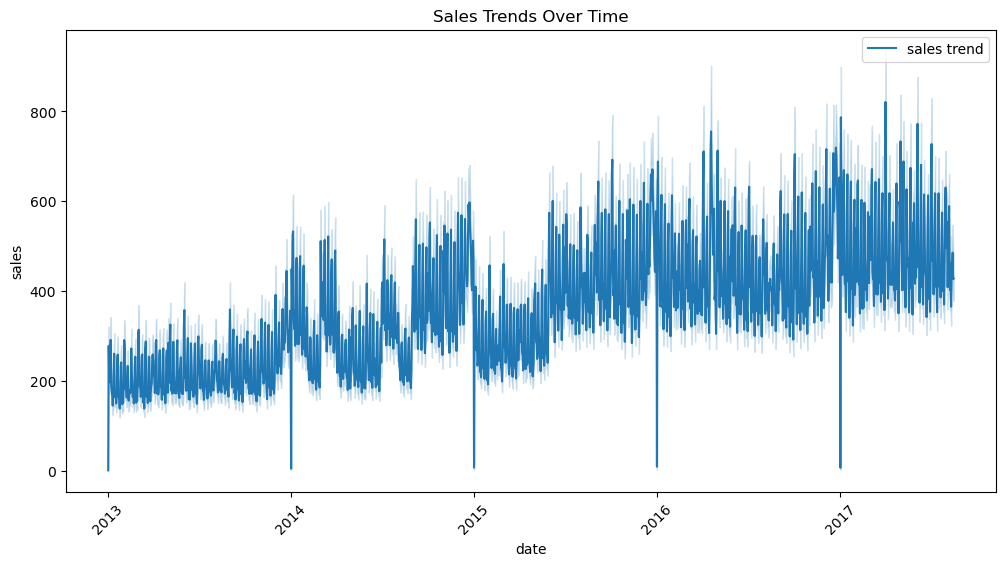

In [228]:
# visualing sales trends over time.
print("EDA")
plt.figure(figsize = (12, 6))
sns.lineplot(x ='date', y = 'sales', data = train, label = 'sales trend' )
plt.title('Sales Trends Over Time')
plt.xlabel('date')
plt.ylabel('sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

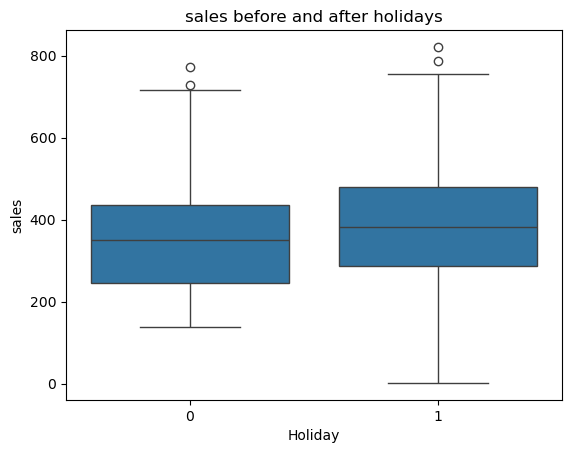

In [230]:
# Analysis of sales before and after holidays and promotions
holiday_sales = train.groupby(['date', 'is_holiday'])['sales'].mean().reset_index()
sns.boxplot(x='is_holiday', y = 'sales', data=holiday_sales)
plt.title('sales before and after holidays')
plt.xlabel('Holiday')
plt.ylabel('sales')
plt.show()

correlation of sales vs oil
               sales  dcoilwtico
sales       1.000000   -0.079009
dcoilwtico -0.079009    1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

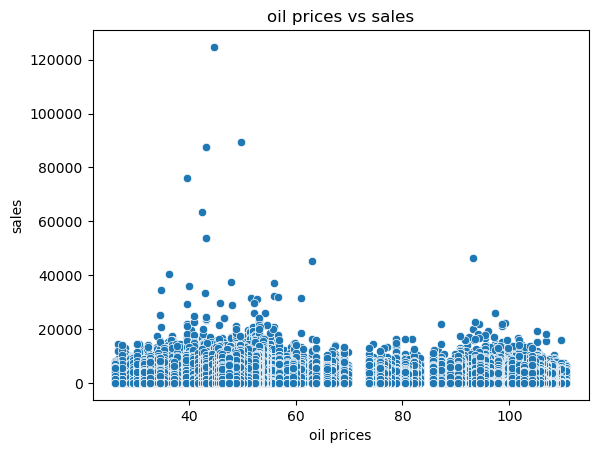

In [232]:
# check for correlation between oil prices and sales trends
correlation = train[['sales', 'dcoilwtico']].corr()
print("correlation of sales vs oil")
print(correlation)
sns.scatterplot(x='dcoilwtico', y ='sales', data=train)
plt.title('oil prices vs sales')
plt.xlabel('oil prices')
plt.ylabel('sales')
plt.show

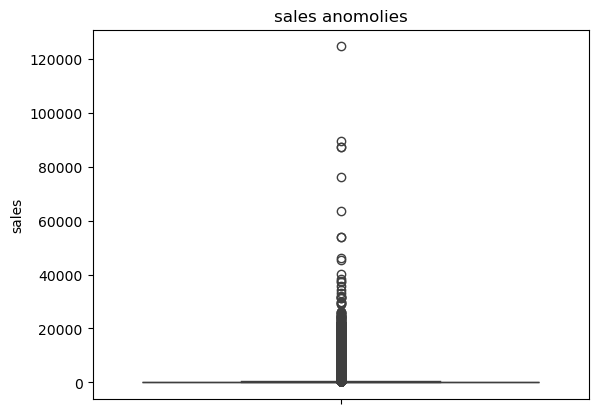

In [248]:
# identify anomolies in the data
sns.boxplot(y = 'sales', data =train)
plt.title('sales anomolies')
plt.ylabel('sales')
plt.show()

#save progress of train csv
train.to_csv('processed_train.csv', index = False)

## Model Training

In [250]:
train = pd.read_csv(r"C:\Users\srinivas\Desktop\Forecasting assignment\processed_train.csv", parse_dates=['date'], low_memory=False)

In [252]:
# Naive forecasting or base model here we have to assume future sales = previous sales
train['naive_forecast'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)

In [259]:
# preparing training data
features = ['day', 'week', 'month', 'year', 'day_of_week', 'is_holiday', 'is_weekend', 
            'is_gov_payday', 'earthquake_impact', 'sales_lag_7', 'sales_lag_30', 
            'rolling_mean_7', 'rolling_std_7', 'avg_store_sales']
X = train[features].dropna()
y = train.loc[X.index, 'sales']

In [261]:
# split into train and test validation sets
train_size = int(len(X)*0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


In [269]:
y_train_sample = y_train.iloc[-10000:]  # Use only the last 10,000 records due to low processing power

In [271]:
# Use ARIMA model
arima_model = ARIMA(y_train, order=(2,1,0))
arima_model_fit = arima_model.fit(low_memory=True)
arima_preds = arima_model_fit.forecast(steps = len(y_val))

C:\Users\srinivas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\srinivas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\srinivas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\srinivas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [275]:
# Random Forest regressor
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs= -1, bootstrap=False, random_state=42)
X_sample, y_sample = X_train.sample(50000, random_state=42), y_train.loc[X_train.sample(50000, random_state =42).index]
rf_model.fit(X_sample, y_sample)
rf_preds = rf_model.predict(X_val)

In [277]:
rf_model.fit(X_sample, y_sample)

RandomForestRegressor(bootstrap=False, max_depth=10, n_estimators=50, n_jobs=-1,
                      random_state=42)

In [279]:
rf_model.predict(X_sample)

array([191.5412496 ,   3.24605501, 313.21990291, ..., 489.70811932,
        39.93198059,  15.44235662])

In [281]:
# Use XGB model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators = 100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

In [285]:
# Model Evaluation
def eval_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2%}, R2: {r2:.2f}")
    

In [291]:
# evaluate_model(y_val, arima_preds, "ARIMA")
print("Model Evaluation")
evaluate_model(y_val, arima_preds, "ARIMA")
evaluate_model(y_val, rf_preds, "Random Forest")
evaluate_model(y_val, xgb_preds, "XGBoost")

Model Evaluation
ARIMA - RMSE: 1411.32, MAPE: 10195183152728449024.00%, R2: -0.06
Random Forest - RMSE: 431.90, MAPE: 975344682013655424.00%, R2: 0.90
XGBoost - RMSE: 307.43, MAPE: 728251545701144448.00%, R2: 0.95


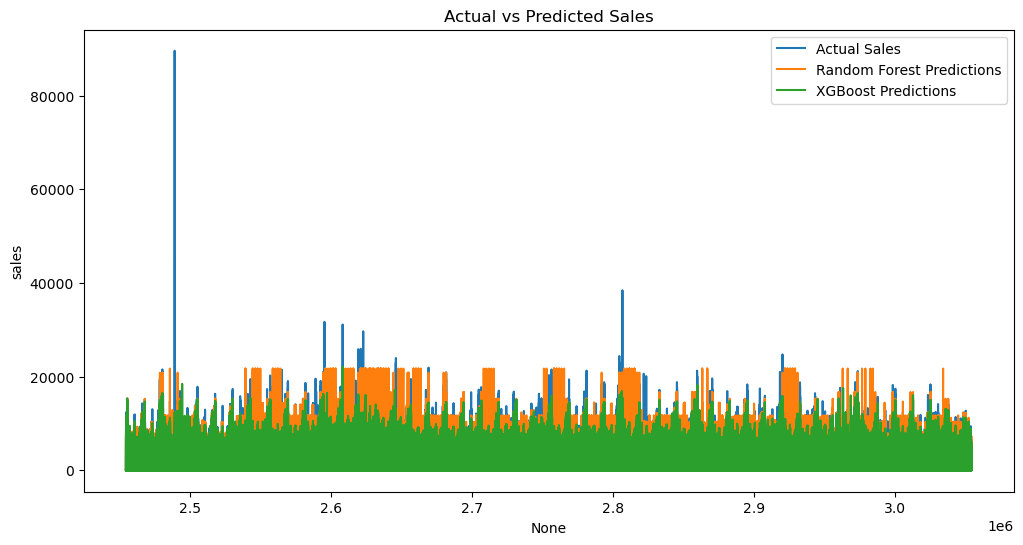

In [293]:
# Visualisation of predicted forecasting models
plt.figure(figsize=(12, 6))
sns.lineplot(x=y_val.index, y=y_val, label='Actual Sales')
sns.lineplot(x=y_val.index, y=rf_preds, label='Random Forest Predictions')
sns.lineplot(x=y_val.index, y=xgb_preds, label='XGBoost Predictions')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()

### from the given error metrics and graph XGB model has performed well by acheiving low RMSE and high R2 value, which makes it a superior model.
- findings:
- sales showed a significant improvement during national holidays.
- Negative correlation between oil prices and sales suggest that increased oil prices have decresed sales.
- promotional events have impacted the sales positively suggesting an upward trend.
### Strategies need to be modified according to findings by otimising inventory levels as per forecast, increasing promotional activities during low sales periods as per forecast, oil price monitoring to be prepared for low sales volumes, and be prepared for critical stock out scenarios, inventory planning, Increased customer satisfaction.